# Permutation Importance... 
#### (and grudgenly the builtin feature importence for sklearn RandomForestClassifier)
Ref:<br> 
<a href="https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance">Permutation importance</a><br>
<a href="https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html">Feature importances with a forest of trees¶</a><br>
<a href="https://github.com/rasbt/stat451-machine-learning-fs21/blob/main/13-feature-selection/05_permutation-importance.ipynb">Permutation Importance by Sebastian Raschka</a><br>


This is part of 'Explainable AI', which answers the question 'Why did it do that?'

There are a lot lot of algorithms that help in this area, two are:<br>
   **Feature importance** calculated per feature (column).  Is based on mean decrease in impurity. - applies to random forest and available via feature_importances_ attribute.  Computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.  Favors  high cardinality features over low.<br>
   **Permutation importance** calculated per feature (column).  Is based on how much a models score decreases when a column is randomly scrambled. <mark>Applies to any model</mark>.  Computed per column as the difference between baseline accuracy and scrambled column accuracy.  The features with the biggest drop in accuracy are the most important to the model.
   
   <mark>Of the 2, favor permutation importance since you can use it with any model and does not suffer from the high cardinality problem of Feature Importence
   

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# Load Data
Lets work with the wine dataset

In [2]:
from sklearn.datasets import load_wine
data = load_wine()

df = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + ['target'])
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


## Any correlations?  If so dump em
Correlations interfere with calculating importance.  For instance, if you have 2 highly correlated columns; A and B.  If you scramble A then B still has As information.  This will result in a lower importance value for both features, where they might actually be important.

In [16]:
# fig, ax = plt.subplots(figsize=(15, 15))
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
print(f'Dropping {to_drop}')
df=df.drop(columns=to_drop)

Dropping []


## Get train/test split

In [17]:
y=df['target']
X=df.drop(columns=['target'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

feature_names = X.columns
forest = RandomForestClassifier(n_estimators=100,random_state=0, oob_score=True)
forest.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=0)

## How well did it do?

In [20]:
#lets see how well it does

#manually
print('Training accuracy:', np.mean(forest.predict(X_train) == y_train)*100)
print('Test accuracy:', np.mean(forest.predict(X_test) == y_test)*100)

#by testing on test data
print('Model score: ', forest.score(X_test, y_test))

#or by OOB data
print(f'OOB error={forest.oob_score_}')

Training accuracy: 100.0
Test accuracy: 100.0
Model score:  1.0
OOB error=0.9774436090225563


# Feature Importence (but prefer Permutation importence)
lets see what the random forest thinks is important, it calculates them based on a mean decrease in impurity, but favors high cardinality columns 


In [7]:
%%time
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

CPU times: user 14.6 ms, sys: 339 µs, total: 14.9 ms
Wall time: 11.3 ms


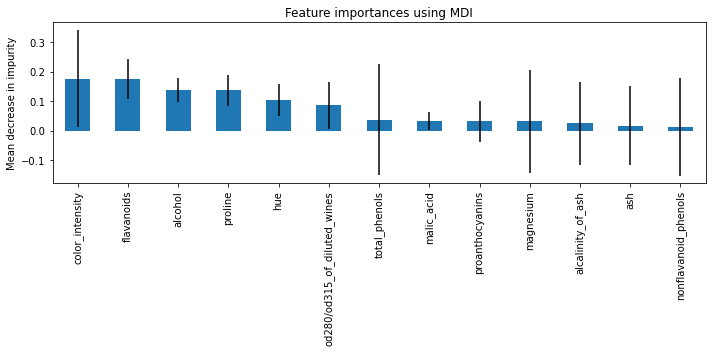

In [8]:
#plot em
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# <mark> Permutation Importance - this is what you want to use
The computation for full permutation importance is more costly. Features are shuffled n times then the results averaged to estimate the importance of it. Please see 
    <a href="https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance">Permutation feature importance</a> for more details.

In [21]:
from sklearn.inspection import permutation_importance

In [22]:
%%time
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring='accuracy')
forest_importances = pd.Series(result.importances_mean, index=feature_names)

CPU times: user 201 ms, sys: 13.1 ms, total: 214 ms
Wall time: 1.09 s


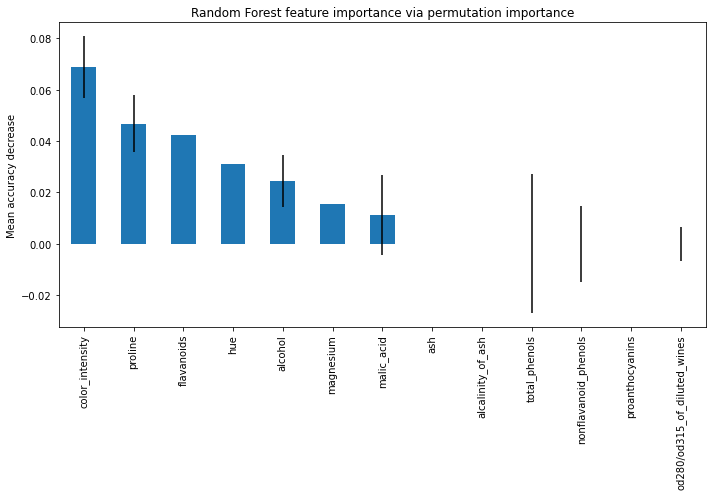

In [24]:
#plot em
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Random Forest feature importance via permutation importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# <mark>Based on Permutation and Feature importance color intensity is the most important features that the model uses to determine the target